# <font style="color:blue">Table of Content</font>

- [Step 1: Understand Your Problem](#step1)
- [Step 2: Get the Data](#step2)
- [Step 3. Data Preparation](#step3)
- [Step 4: Train a Simple Model](#step4)
- [Step 5: Sample Prediction](#step5)
- [Step 6. Display Mistakes](#step6)

# <font style="color:blue">Project 1 - Part 2: Train an Image Classifier From Scratch</font>
As discussed in the previous notebook, the steps for training Neural Networks are:

- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore and understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data preparation
- Step 4 - Train a simple model on sample data and check the pipeline before proceeding to train the full network
- Step 5 - Train on full data
- Step 6 - Improve your model

You have already been through Steps `1-4` in the previous notebook. Use them here as well.

Here, you will implement Steps `5` & `6` from scratch. Design a model that achieves `>=85%` validation accuracy on the given dataset.

There are 70 points for this notebook. The sections which carry marks are in Red.

There are **70 points** for this notebook. <font style="color:red">The sections which carry marks are in Red.</font>

For GPU compute you can use Kaggle Kernels, Google Colab or any other service of your choice.

After completing the assignment, upload and submit it on the portal for feedback.

<font style="color:red">Use the full data to train the network. You need to achieve 85% accuracy for validation data to successfully complete this assignment.</font>


<font style="color:red">Just remember to build your own model, not use any pre-trained models/weights.</font>


Upon completing the assignment, <font style="color:red">upload the notebook and the models folder on the portal for  feedback.</font>

# <font style="color:blue">Step 1: Understand Your problem </font><a name="step1"></a>
Already covered in the previous notebook.

# <font style="color:blue">Step 2: Get the Data </font><a name="step2"></a>

Already covered in the previous notebook.

In [1]:
!wget "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1" -O data.zip

--2023-10-11 15:04:58--  https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/dl/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra [following]
--2023-10-11 15:04:58--  https://www.dropbox.com/sh/dl/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc97f2ca6026e6f4859073c35983.dl.dropboxusercontent.com/zip_download_get/BozygsKRNkacys-sU3hHnCfa524UJpAryLmiIvknUwe_Zfit8fIujI1xj478rDUVgLj4fLnzM9j-Ia5Tm6G9LPd-ikTr7Y20QGwbxktOIxw7rg?dl=1# [following]
--2023-10-11 15:04:59--  https://uc97f2ca6026e6f4859073c35983.dl.dropboxusercontent.com/zip_download_get/BozygsKRNkacys-sU3hHnCfa524UJpAryLmiIvknUwe_Zfit8fIujI1xj478rDUVgLj4fLnzM9j-Ia5Tm6G9LPd-

### <font style="color:green">Extract the Data</font>

In [2]:
!unzip -q data.zip

mapname:  conversion of  failed


# <font style="color:blue">Step 3. Data Preparation</font><a name="step3"></a>
Already covered in the previous notebook.

## <font style="color:blue">3.1. Import Libraries </font>

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

### <font style="color:green">3.2.1. Compulsary Preprocessing Transforms</font>

In [6]:
def image_preprocess_transforms():

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])

    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>

In [7]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()

    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])

    return common_transforms


### <font style="color:green">3.2.3. Mean and STD</font>

In [8]:
def get_mean_std(data_root, num_workers=4):

    transform = image_preprocess_transforms()

    loader = data_loader(data_root, transform)

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i]
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean ** 2)

    std = var ** 0.5
    print('mean: {}, std: {}'.format(mean, std))

    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>
Data loader for generating batches of data to be used by the training routine

In [9]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)

    return loader

## <font style="color:green">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [10]:
from torchvision.transforms.transforms import RandomVerticalFlip
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):

    train_data_path = os.path.join(data_root, 'training')

    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    common_transforms = image_common_transforms(mean, std)

    if data_augmentation:
      additional_augmentations = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color,
      ])
      train_transforms = transforms.Compose([
          additional_augmentations,
          common_transforms
      ])
    else:
      train_transforms = common_transforms

    # Train data loader
    train_loader = data_loader(
        train_data_path,
        train_transforms,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers)

    # Test data loader
    test_data_path = os.path.join(data_root, 'validation')

    test_loader = data_loader(test_data_path,
                              common_transforms,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers)


    return train_loader, test_loader

# <font style="color:blue">Step 4: Train Your Model</font><a name="step4"></a>

Now, create the training pipeline, and train your model on the full data.

## <font style="color:red">4.1. Configurations [20 Points]</font>

To achieve good results, change the parameters given in these configurations. Score 20 points for all right choices.

### <font style="color:green">4.1.1. System Configuration</font>

Fix the seed (e.g., `21`) to get a reproducible result.

In [11]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [12]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32
    epochs_count: int = 150
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    log_interval: int = 5
    test_interval: int = 1
    data_root: str = "./cat-dog-panda"
    num_workers: int = 2
    device: str = 'cuda'



### <font style="color:green">4.1.3. System Setup</font>

In [13]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>

You are already familiar with the training function. No changes needed here.

In [14]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:

    # change model in training mood
    model.train()

    # to get batch loss
    batch_loss = np.array([])

    # to get batch accuracy
    batch_acc = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):

        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = model(data)

        # cross entropy loss
        loss = F.cross_entropy(output, target)

        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()

        batch_loss = np.append(batch_loss, [loss.item()])

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()

        # accuracy
        acc = float(correct) / float(len(data))

        batch_acc = np.append(batch_acc, [acc])

    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In [15]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    #
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)

        target = target.to(train_config.device)

        with torch.no_grad():
            output = model(data)

        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)

    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )

    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [16]:
def save_model(model, device, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

## <font style="color:blue">4.5. Load the Model</font>

In [17]:
def load_model(model, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))

    return model

## <font style="color:blue">4.6. Main Function for Training</font>

Note: Before calling the train function, we calculate the validation loss, which we know should be close to $\log(\text{num_classes})$. Also, the accuracy should be close to $\frac{1}{\text{num_classes}}$.

In [18]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(),
         training_configuration=TrainingConfiguration(), data_augmentation=True):

    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config,
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )

    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss,
                                                                                   init_val_accuracy*100))

    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):

        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}sz9".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # scheduler step/ update learning rate
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)


    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [19]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left',
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()

    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = train_loss[i].min()

        min_val_loss = val_loss[i].min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID LOSS ({0:.4})".format(min_val_loss))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = train_acc[i].max()

        max_val_acc = val_acc[i].max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ACC ({0:.4})".format(max_val_acc))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')

    fig.savefig('sample_loss_acc_plot.png')
    plt.show()

    return

## <font style="color:red">4.8. Define Model [20 Points]</font>

Next, define the CNN model. Keep iterating. Do this by training various models. Just ,change the :
    
- number of layers
- parameters inside the layers
- different types of layers

In [20]:
class MyModel(nn.Module):

    def __init__(self, dropout=0.0, batch_norm=False):
      super().__init__()

      # Convolution layers
      self._body = nn.Sequential(
          # First convolution Layer
          # input size = (224, 224), output size = (220, 220)
          nn.Conv2d(in_channels=3, out_channels=18, kernel_size=5),
          # Apply batch norm
          nn.BatchNorm2d(18),
          # ReLU activation
          nn.ReLU(inplace=True),
          # Max pool 2-d
          nn.MaxPool2d(kernel_size=2),
          # output(110, 110)


          # Second convolution layer
          # input size = (110, 110), output size = (106, 106)
          nn.Conv2d(in_channels=18, out_channels=54, kernel_size=5),
          # Apply batch norm
          nn.BatchNorm2d(54),
          # ReLU activation
          nn.ReLU(inplace=True),
          # Max pool 2-d
          nn.MaxPool2d(kernel_size=2),
          # output size = (53, 53)


          # Third convolution layer
          # input size = (53, 53), output size = (53, 53)
          nn.Conv2d(in_channels=54, out_channels=162, kernel_size=2, padding=1),
          # Apply batch norm
          nn.BatchNorm2d(162),
          # ReLU activation
          nn.ReLU(inplace=True),
          # Max pool 2-d
          nn.MaxPool2d(kernel_size=2),
          # output (27, 27)


          # Fourth convolution layer
          # input size = (27, 27), output size = (23, 23)
          nn.Conv2d(in_channels=162, out_channels=324 , kernel_size=5),
          # Apply batch norm
          nn.BatchNorm2d(324),
          # ReLU activation
          nn.ReLU(inplace=True),
          # Max pool 2-d
          nn.MaxPool2d(kernel_size=2),
          # output (11, 11)
          nn.Dropout(dropout)

      )

      # Fully connected layers
      self._head = nn.Sequential(
          # First fully connected layer
          # in_features = 324 * 11 * 11
          nn.Linear(in_features=(324 * 11 * 11), out_features=2048),

          # ReLU activation
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          # Second fully connected layer
          nn.Linear(in_features=2048, out_features=1024),

          # ReLU activation
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          # Third fully connected layer. It is also the output layer
          nn.Linear(in_features=1024, out_features=512),

          # ReLU activation
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          # Fourth fully connected layer. It is also the output layer
          nn.Linear(in_features=512, out_features=256),

          # ReLU activation
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          # Fifth fully connected layer. It is also the output layer
          nn.Linear(in_features=256, out_features=168),

          # ReLU activation
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          # Sixth fully connected layer. It is also the output layer
          nn.Linear(in_features=168, out_features=81),

          # ReLU activation
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          # Seventh fully connected layer. It is also the output layer
          nn.Linear(in_features=81, out_features=40),

          # ReLU activation
          nn.ReLU(inplace=True),
          nn.Dropout(dropout),

          # Eigth fully connected layer. It is also the output layer
          nn.Linear(in_features=40, out_features=3),
      )

    def forward(self, x):
          # Apply feature extractor
          x = self._body(x)
          # Flatten the output of conv layers
          x = x.view(x.size(0), -1)
          # Apply classification head
          x = self._head(x)
          return x


## <font style="color:red">4.9. Training [20 Points]</font>

Experiment with:

- Optimizers and learning rate schedulers \[You can  get good results even without a learning rate scheduler\]

- Regularization techniques like Data Augmentation, Dropout, BatchNorm

In [21]:
model = MyModel(0.25)
print(model)

# get optimizer
train_config = TrainingConfiguration()

### CHANGE HERE ###

# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

verbose = True
T_max = 250

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=0, last_epoch=-1, verbose=verbose)


MyModel(
  (_body): Sequential(
    (0): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(18, 54, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(54, 162, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(162, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(162, 324, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(324, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(i

In [22]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=None, data_augmentation=True)

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2734, 0.2641, 0.2616])

Test set: Average loss: 1.1029, Accuracy: 200/600 (33%)

Initial Test Loss : 1.102925, 
Initial Test Accuracy : 33.333%

Epoch: 0 
Train Loss: 1.010315 Acc: 0.4850
Elapsed 48.30s, 48.30 s/epoch, 0.64 s/batch, ets 7196.94sz9

Test set: Average loss: 0.9152, Accuracy: 323/600 (54%)

Model Improved. Saving the Model...

Epoch: 1 
Train Loss: 0.869174 Acc: 0.5646
Elapsed 101.09s, 50.54 s/epoch, 0.67 s/batch, ets 7480.59sz9

Test set: Average loss: 0.6936, Accuracy: 375/600 (62%)

Model Improved. Saving the Model...

Epoch: 2 
Train Loss: 0.788589 Acc: 0.5767
Elapsed 152.73s, 50.91 s/epoch, 0.68 s/batch, ets 7483.65sz9

Test set: Average loss: 0.6801, Accuracy: 358/600 (60%)

Model Improved. Saving the Model...

Epoch: 3 
Train Loss: 0.731038 Acc: 0.6067
Elapsed 206.30s, 51.57 s/epoch, 0.69 s/batch, ets 7529.77sz9

Test set: Average loss: 0.6745, Accuracy: 364/600 (61%)

Model Improved. Saving the Model...

Epoch

## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

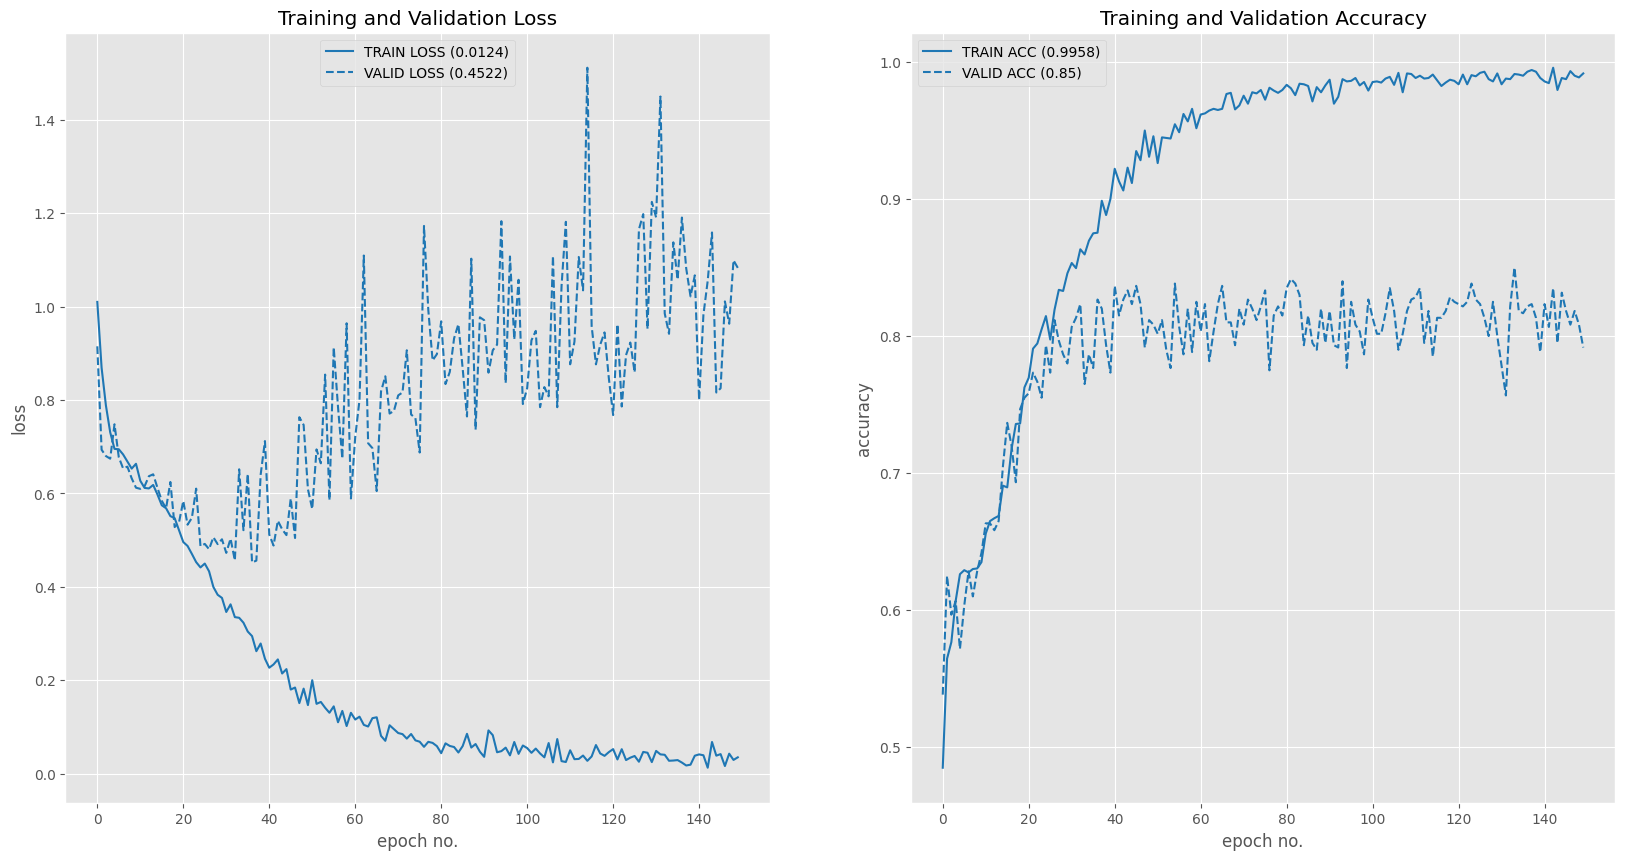

In [23]:
plot_loss_accuracy(train_loss=[train_loss],
                   val_loss=[val_loss],
                   train_acc=[train_acc],
                   val_acc=[val_acc],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

# <font style="color:blue">Step 5. Sample Prediction</font><a name="step5"></a>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [24]:
def prediction(model, device, batch_input):

    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]

    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get Predictions on a Batch</font>

In [25]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction
    model.eval()

    # Send model to cpu/cuda according to your system configuration
    model.to(device)

    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))

    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())

    data_len = test_dataset.__len__()

    interval = int(data_len/batch_size)

    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()


    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]],
                                                     prob[i],
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()

    return test_dataset, targets, cls, prob



In [26]:
def get_data_conf_matrix(model, data_root, mean, std):
    ''' This function will be used to determine the confusion matrix over all

    the data set. Similar to the previous function without batch and  plotting steps'''

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction
    model.eval()

    # Send model to cpu/cuda according to your system configuration
    model.to(device)

    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))

    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())

    data_len = test_dataset.__len__()

    imgs = []
    inputs = []
    targets = []
    for i in range(data_len):
        trans_input, target = test_dataset_trans.__getitem__(i)
        img, _ = test_dataset.__getitem__(i)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)

    return test_dataset, targets, cls, prob

## <font style="color:blue">5.3. Load Model and Run Inference</font>

mean: tensor([0.4610, 0.4347, 0.3897]), std: tensor([0.2734, 0.2641, 0.2616])


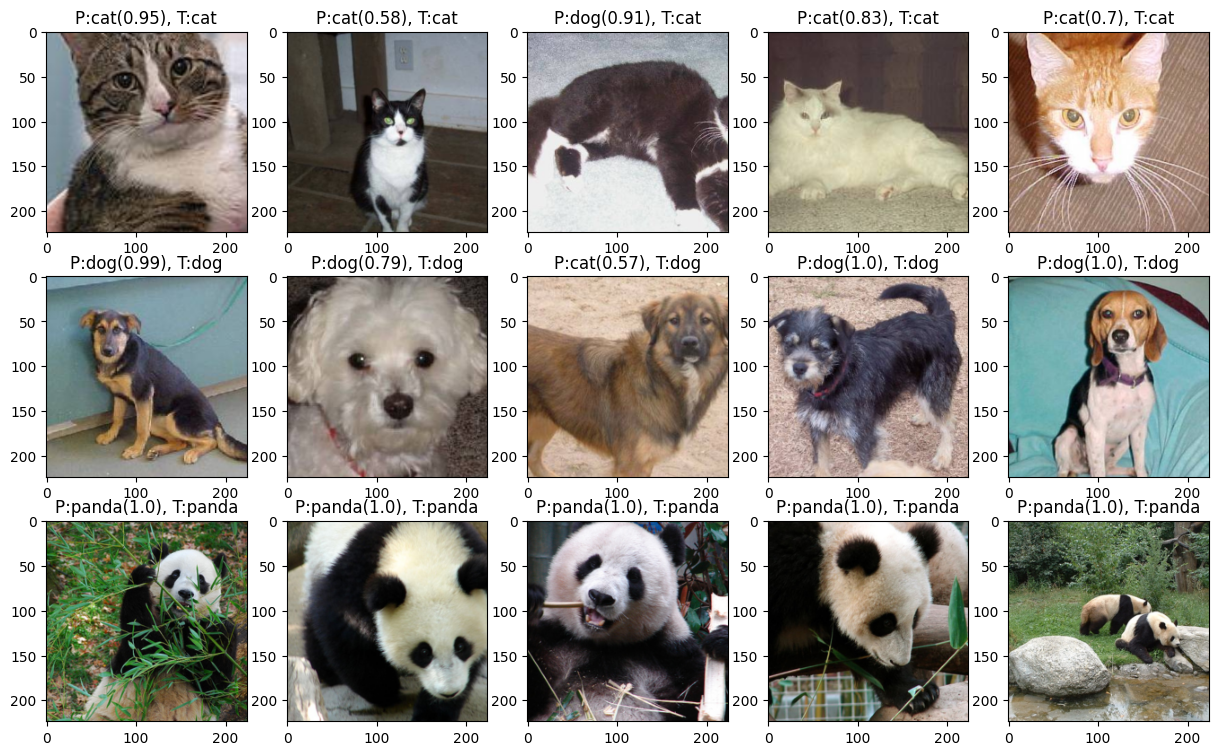

In [27]:
m = MyModel()
m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')
train_data_path = os.path.join(train_config.data_root, 'training')

mean, std = get_mean_std(train_data_path)

test_dataset, targets, cls, prob=get_sample_prediction(m, test_data_path, mean, std)
test_dataset_conf_matrix, targets_conf_matrix, cls_conf_matrix, prob_conf_matrix = get_data_conf_matrix(m, test_data_path, mean, std)

# <font style="color:red">Step 6. Display Confusion Matrix [10 Points]</font><a name="step6"></a>

Display the confusion matrix for the above problem(Refer to the earlier lectures on Performance Metrics).


The output should resemble this:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/02/c3_w5_sample_confusion_matrix.png' width=600>


In [28]:
import pandas as pd

from sklearn import datasets, svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

['cat', 'dog', 'panda']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

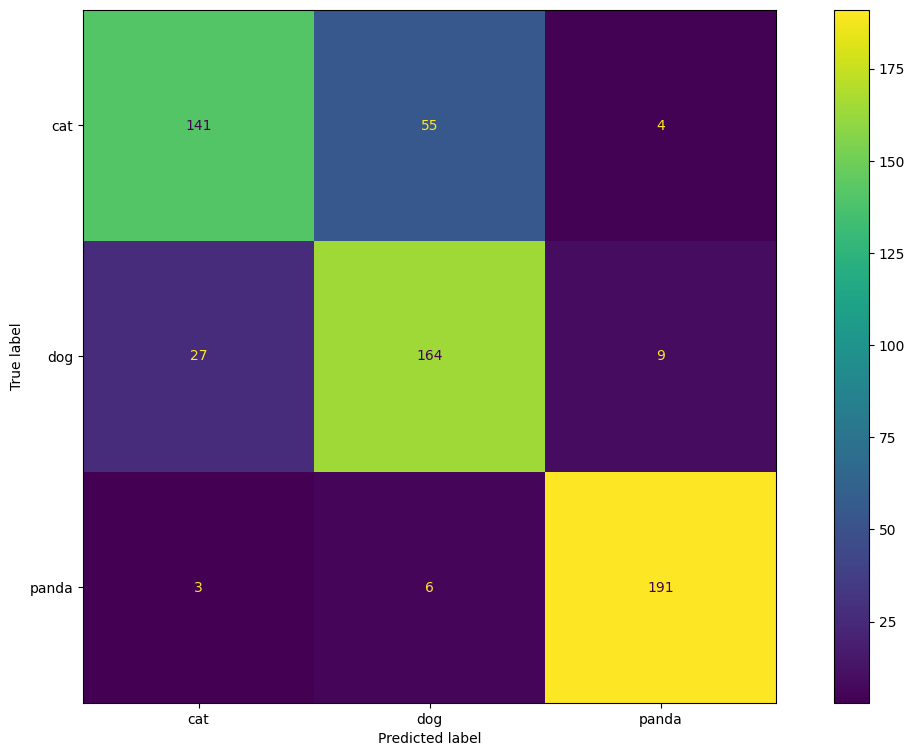

In [29]:
labels = test_dataset_conf_matrix.classes
print(labels)
print()

y_true = targets_conf_matrix
print(y_true)
print()

y_pred = cls_conf_matrix
print(y_pred)
print()

print(prob_conf_matrix)

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()



Upon completing the assignment,  <font style="color:red">pload the 2 notebooks and the models folder on the portal for feedback.</font>